In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# MODELS

## Load pre-processed data

In [2]:
formatted_data = pd.read_csv('data/formatted_data.csv',sep=";")

In [3]:
features = formatted_data.drop(columns=['Target'])
target = formatted_data['Target']

## Random Seed

In [4]:
RANDOM_SEED = 42

## k-Fold Validation

In [5]:
k = 5
cv = StratifiedKFold(n_splits=k, random_state=RANDOM_SEED, shuffle=True)

### ROC Plotting Function


In [6]:
def plot_roc_curve(fprs, tprs, figsize=(14, 10)):
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=figsize)

    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Luck', alpha=.8)

    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std([auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)])
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return fig, ax

In [7]:
def compute_roc_auc(clf, X, y, index):
    y_predict = clf.predict_proba(X.iloc[index])[:, 1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [8]:
def train_and_show_auc(clf, X, y):
    fprs, tprs, scores = [], [], []

    for (train, test), i in zip(cv.split(X, y), range(5)):
        clf.fit(X.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(clf, X, y, train)
        fpr, tpr, auc_score = compute_roc_auc(clf, X, y, test)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)

    plot_roc_curve(fprs, tprs)
    return pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Random Forests

In [9]:
rf_classifier = RandomForestClassifier(random_state=RANDOM_SEED)

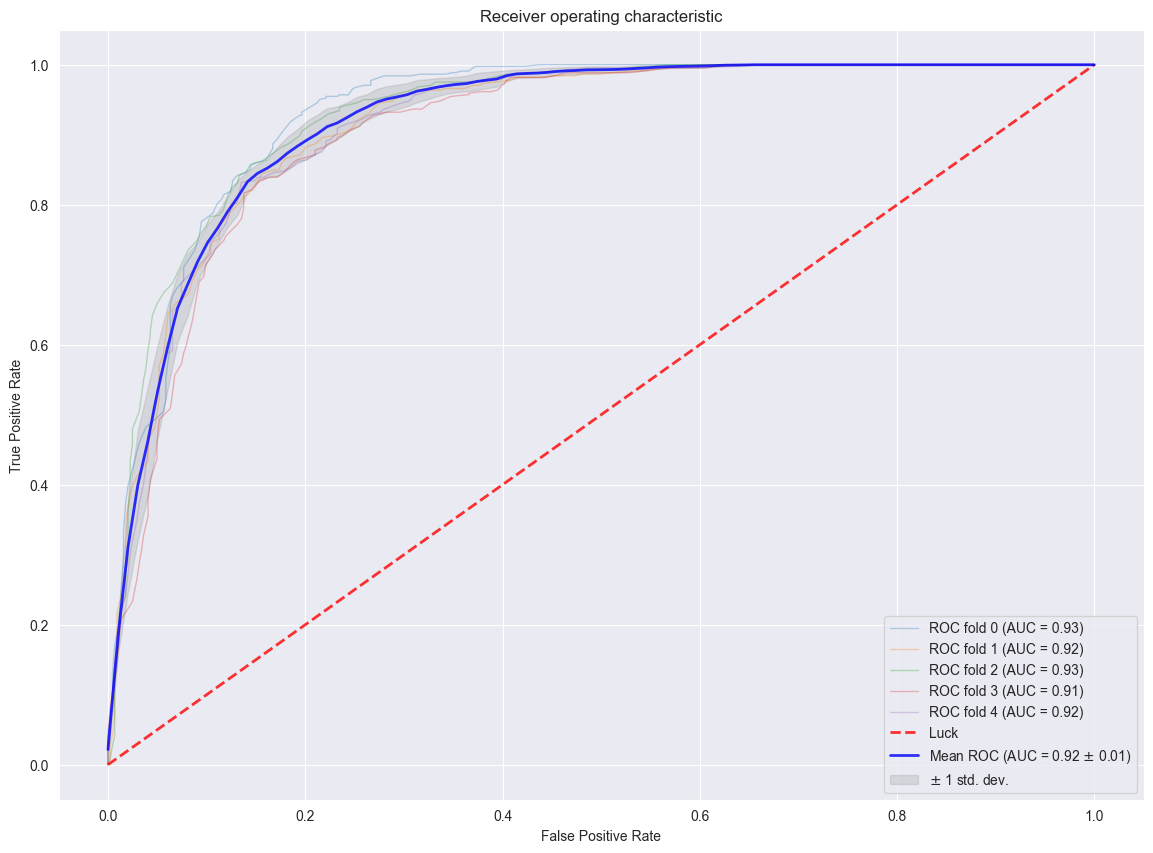

In [10]:
rf_scores = train_and_show_auc(rf_classifier, features, target)

## Gradient Boosting

In [11]:
xgb_classifier = xgb.XGBClassifier(random_state=RANDOM_SEED)

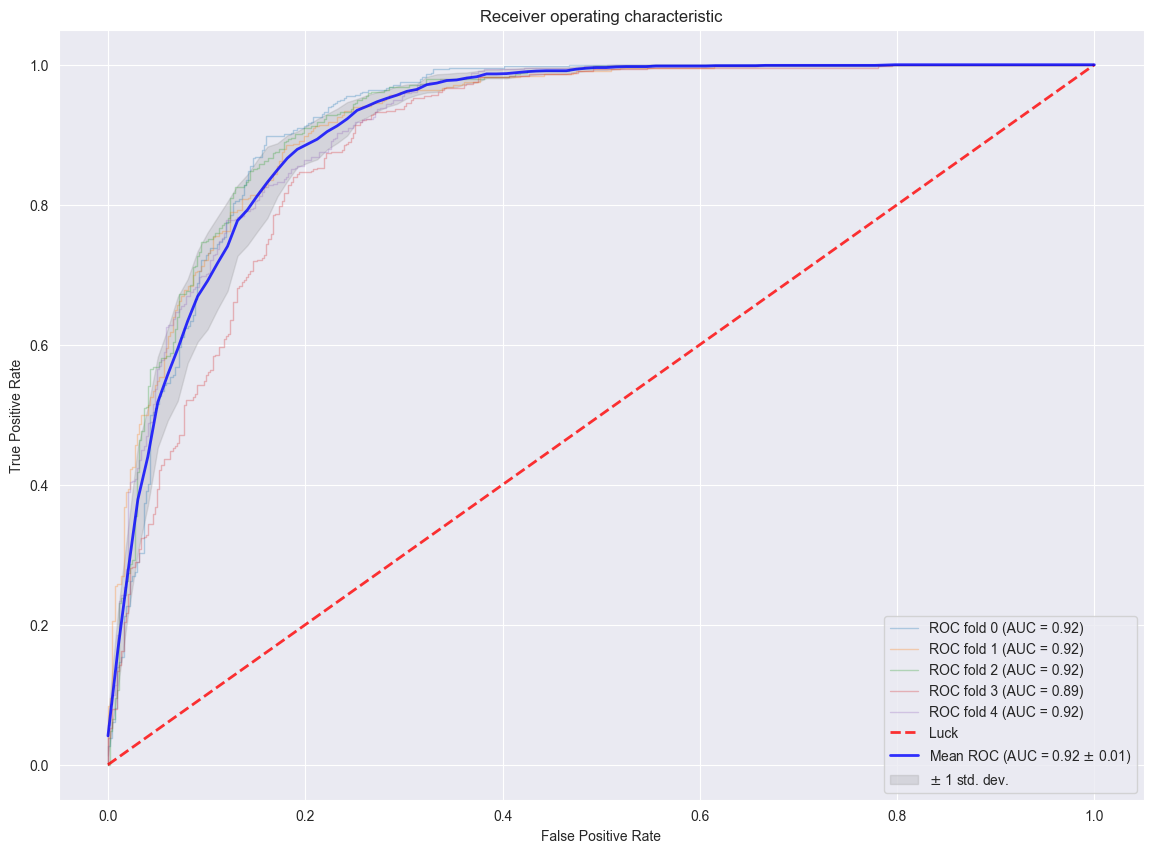

In [12]:
xgb_scores = train_and_show_auc(xgb_classifier, features, target)

## SVM

In [13]:
svm_classifier = SVC(random_state=RANDOM_SEED, probability=True)

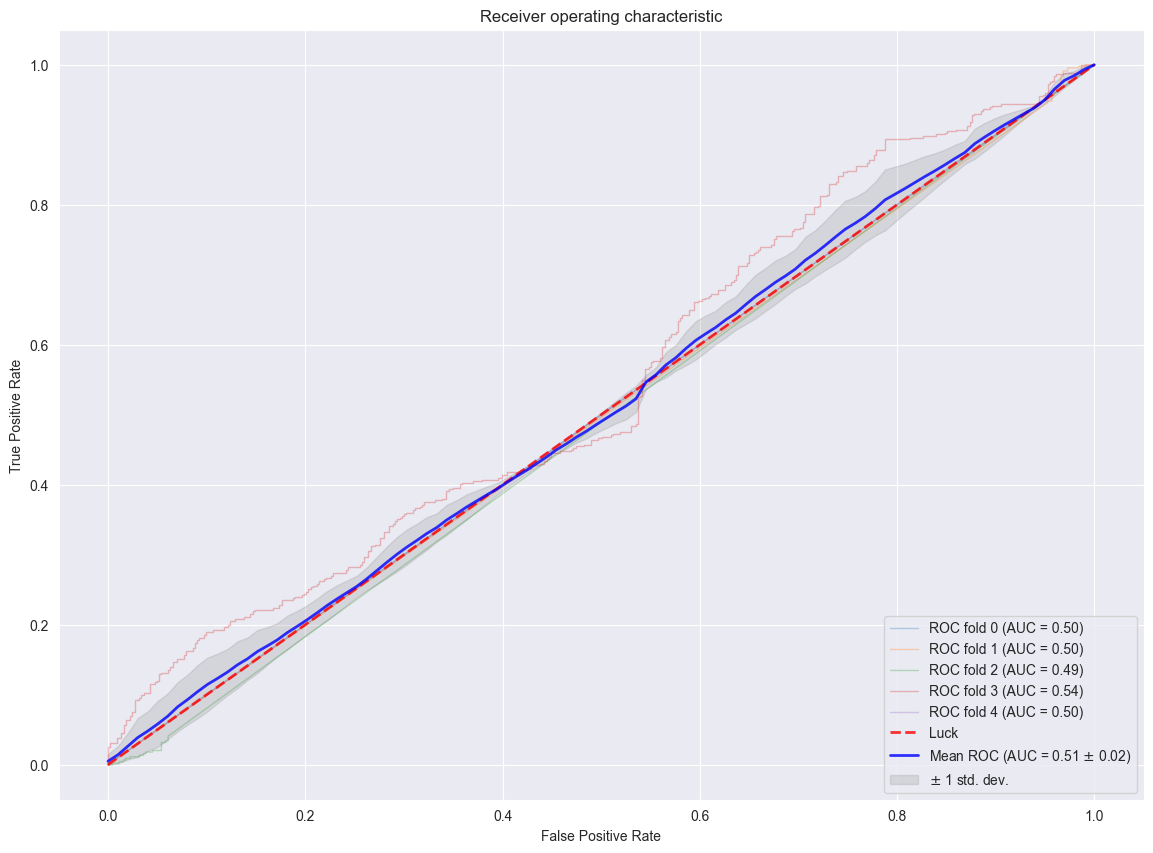

In [14]:
svm_scores = train_and_show_auc(svm_classifier, features, target)

## Logistic Regression

In [15]:
lr_classifier = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)

C:\Users\Lorenzo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lorenzo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

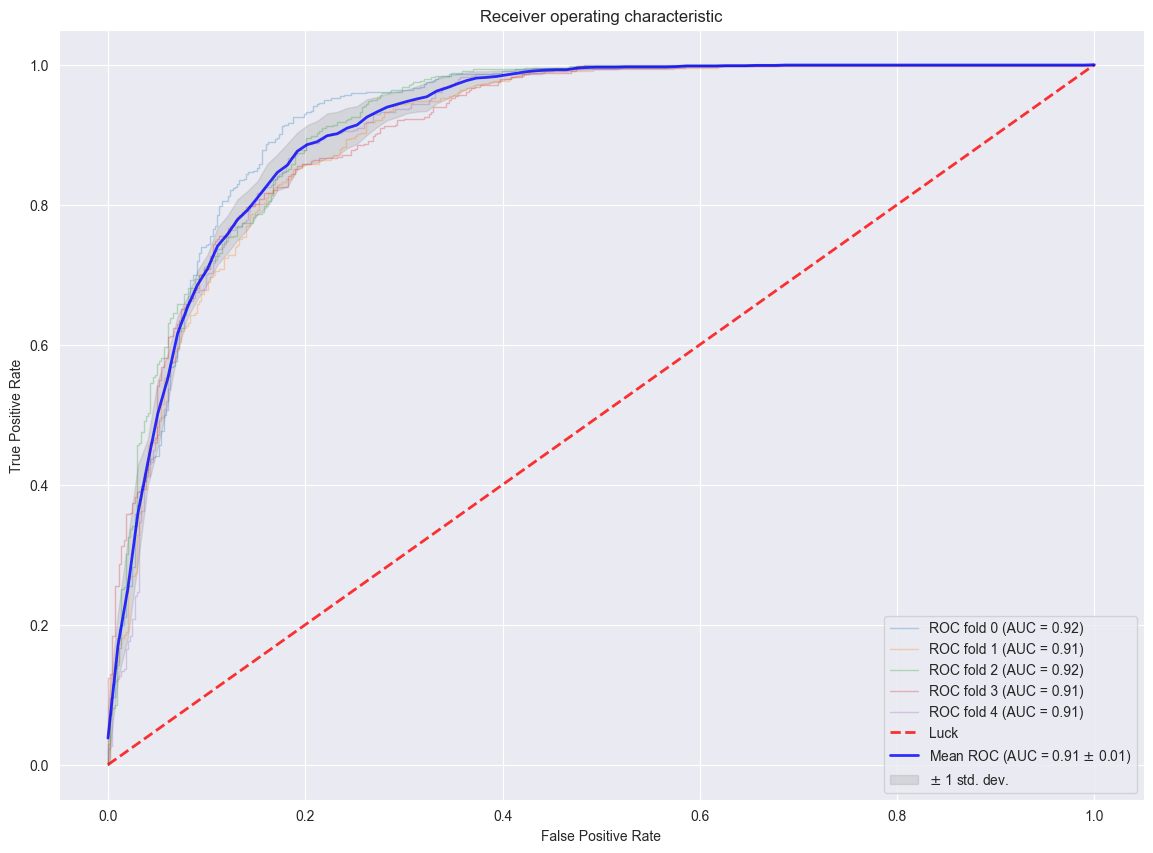

In [16]:
lr_scores = train_and_show_auc(lr_classifier, features, target)

## Neural Network

In [17]:
mlp_classifier = MLPClassifier(random_state=RANDOM_SEED)

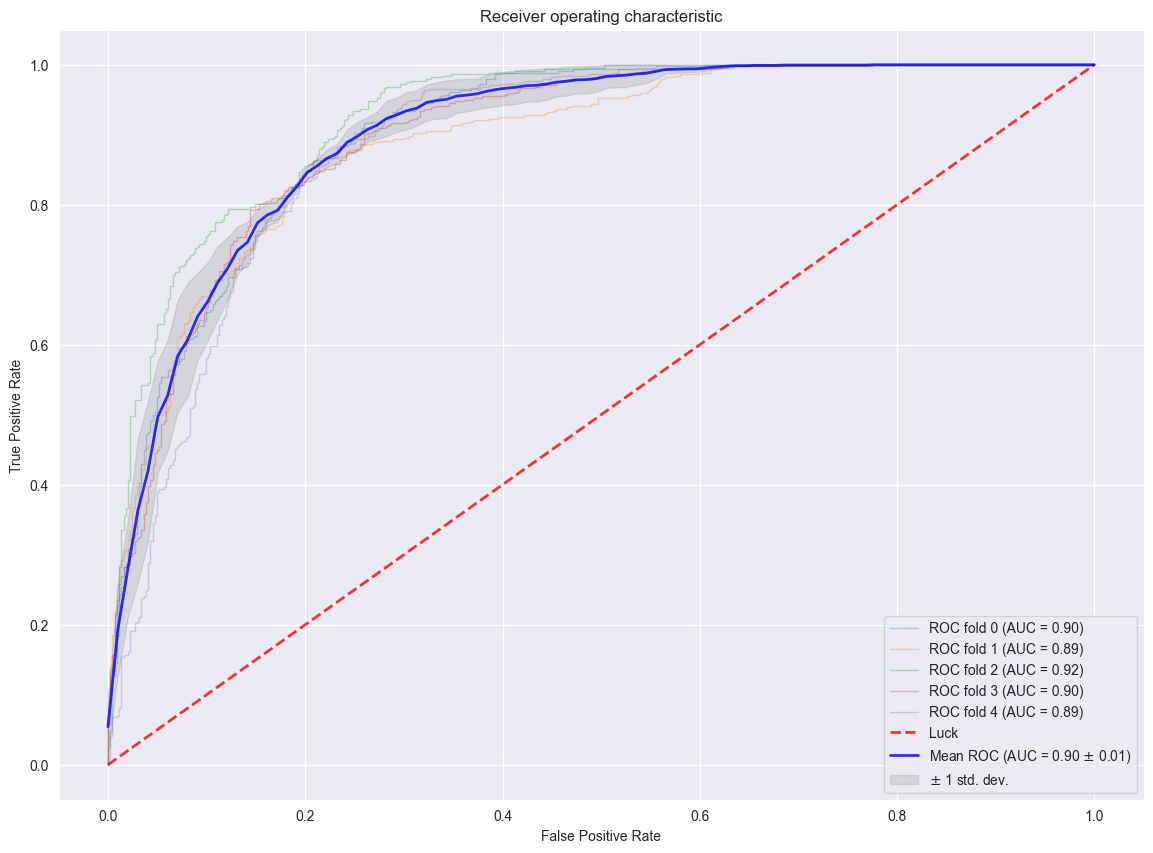

In [18]:
mlp_scores = train_and_show_auc(mlp_classifier, features, target)